In [1047]:
import pandas as pd
import numpy as np
import yfinance as yf
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import math
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

# Índice

1. Coleta de dados
   1. Escolha das Criptomoedas que serão trabalhadas
   2. Criação do dicionário 'data'
   3. Criação do dicionário 'data_complete'
2. Tratamento das tabelas
   1. Criar vetor de dias - First Transform
   2. Separar em treinamento e teste - Permitir Bagging
   3. Bagging
3. Machine Learning
   1. Função do Modelo
   2. Treinamento com Paralelismo e Geração dos Expected Values
4. Preparação para Portifólio
   1. Preparar data_complete para conter volatilidade
   2. Criar vetor de médias
   3. Criar matriz de covariâncias
5. Alocação de Portifólio
   1. Para cada intervalo de tempo, selecionar pesos de portifólio
   2. Calcular retorno desse portifólio no intervalo de tempo
   3. Salvar retorno e analisar resultados

In [1048]:
# HIPERPARÂMETROS:
start_date = '2016-08-21'
W = 80  # Look-Back Window

# 1. Coleta de dados

## 1.1 Escolha das Criptomoedas que serão trabalhadas

In [1049]:
# Criptomoedas que vamos escolher para nosso portifólio
cryptos = [
    'BTC-USD', 'ETH-USD','LTC-USD', 'ADA-USD',
    'DOT-USD', 'LINK-USD','SOL-USD',
    'TRX-USD'
]

## 1.2 Criação do dicionário 'data'

In [1050]:
## Função para calcular o retorno logarítmico
def log_return(series):
    return np.log(series['Close'] / series['Open'])

In [1051]:
data = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1wk')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        'Volume': df['Volume'],
        'Crypto_Return_Today': df['Return']
    }).dropna()

    data[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [1052]:
data['ETH-USD']

,Volume,Crypto_Return_Today
Date,,
2017-11-06,4235016896,-0.002391
2017-11-13,6084391936,0.143458
2017-11-20,9316127936,0.285996
2017-11-27,10504046976,-0.012115
2017-12-04,12094509888,-0.053623
...,...,...
2024-09-16,111863297549,0.106946
2024-09-23,106429244040,0.029216
2024-09-30,112999446307,-0.086079


In [1053]:
aux = yf.download('BTC-USD', start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1wk')
aux['Return'] = log_return(aux)
aux = pd.DataFrame({'BTC-Return': aux['Return']})
aux


[*********************100%%**********************]  1 of 1 completed


,BTC-Return
Date,
2016-08-15,-0.001085
2016-08-22,-0.012810
2016-08-29,0.058464
2016-09-05,-0.003736
2016-09-12,0.004715
...,...
2024-09-16,0.072707
2024-09-23,0.030823
2024-09-30,-0.043847


In [1054]:
for crypto in cryptos:
    data[crypto] = pd.merge(aux, data[crypto],  left_index=True, right_index=True, how='outer').dropna()

In [1055]:
print(len(data['ETH-USD']))
data['LTC-USD']

363


,BTC-Return,Volume,Crypto_Return_Today
Date,,,
2016-08-15,-0.001085,1321380,-0.001200
2016-08-22,-0.012810,33749330,0.033279
2016-08-29,0.058464,18147800,0.071438
2016-09-05,-0.003736,14571252,-0.042177
2016-09-12,0.004715,12749430,0.043743
...,...,...,...
2024-09-16,0.072707,1912761130,0.079805
2024-09-23,0.030823,1896623095,0.010383
2024-09-30,-0.043847,1919950245,-0.032940


In [1056]:
"""global data_std
data_std = {}
global data_mean
data_mean = {}
for crypto in cryptos:
    data_std[crypto] = data[crypto].std()
    data_mean[crypto] = data[crypto].mean()
    data[crypto] = (data[crypto] - data[crypto].mean()) / data[crypto].std()"""

'global data_std\ndata_std = {}\nglobal data_mean\ndata_mean = {}\nfor crypto in cryptos:\n    data_std[crypto] = data[crypto].std()\n    data_mean[crypto] = data[crypto].mean()\n    data[crypto] = (data[crypto] - data[crypto].mean()) / data[crypto].std()'

In [1057]:
print(len(data['ETH-USD']))
data['ETH-USD']

363


,BTC-Return,Volume,Crypto_Return_Today
Date,,,
2017-11-06,-0.218512,4.235017e+09,-0.002391
2017-11-13,0.302578,6.084392e+09,0.143458
2017-11-20,0.148981,9.316128e+09,0.285996
2017-11-27,0.191187,1.050405e+10,-0.012115
2017-12-04,0.311794,1.209451e+10,-0.053623
...,...,...,...
2024-09-16,0.072707,1.118633e+11,0.106946
2024-09-23,0.030823,1.064292e+11,0.029216
2024-09-30,-0.043847,1.129994e+11,-0.086079


## 1.3 Criação do dicionário 'data_complete'

In [1058]:
data_complete = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1wk')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        'Volume': df['Volume'],
        'Crypto_Return_Today': df['Return']
    }).dropna()

    # Adicionar a coluna 'exp_value' com valores NaN
    df_final['exp_value'] = np.nan

    # Armazenar no dicionário
    data_complete[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [1059]:
print(len(data_complete['ETH-USD']))
data_complete['ETH-USD']

363


,Volume,Crypto_Return_Today,exp_value
Date,,,
2017-11-06,4235016896,-0.002391,NaN
2017-11-13,6084391936,0.143458,NaN
2017-11-20,9316127936,0.285996,NaN
2017-11-27,10504046976,-0.012115,NaN
2017-12-04,12094509888,-0.053623,NaN
...,...,...,...
2024-09-16,111863297549,0.106946,NaN
2024-09-23,106429244040,0.029216,NaN
2024-09-30,112999446307,-0.086079,NaN


In [1060]:
"""data_complete_std = {}
data_complete_mean = {}
for crypto in cryptos:
    data_complete_std[crypto] = data_complete[crypto].std()
    data_complete_mean[crypto] = data_complete[crypto].mean()
    data_complete[crypto] = (data_complete[crypto] - data_complete[crypto].mean()) / data_complete[crypto].std()"""

'data_complete_std = {}\ndata_complete_mean = {}\nfor crypto in cryptos:\n    data_complete_std[crypto] = data_complete[crypto].std()\n    data_complete_mean[crypto] = data_complete[crypto].mean()\n    data_complete[crypto] = (data_complete[crypto] - data_complete[crypto].mean()) / data_complete[crypto].std()'

In [1061]:
print(len(data_complete['ETH-USD']))
data_complete['ETH-USD']

363


,Volume,Crypto_Return_Today,exp_value
Date,,,
2017-11-06,4235016896,-0.002391,NaN
2017-11-13,6084391936,0.143458,NaN
2017-11-20,9316127936,0.285996,NaN
2017-11-27,10504046976,-0.012115,NaN
2017-12-04,12094509888,-0.053623,NaN
...,...,...,...
2024-09-16,111863297549,0.106946,NaN
2024-09-23,106429244040,0.029216,NaN
2024-09-30,112999446307,-0.086079,NaN


# 2. Tratamento das tabelas

## 2.1 Criar vetor de dias - First Transform

In [1062]:
# Criando a função First Transformation, que recebe uma tabela contendo os retornos de todos os dias dos ultimos X anos e retorno um vetor, que cada elemento
# é uma tabela do retorno de W+1 dias.
def FirstTransform(df, W):
    vet = []
    Linhas, Colunas = df.shape
    for i in range(Linhas, W+1, -1):
        vet.append(df.iloc[(i-W-1):i])
    return vet

In [1063]:
for crypto in cryptos:
    data[crypto] = FirstTransform(data[crypto], W)

In [1064]:
print(len(data['ETH-USD']))
data['ETH-USD'][0]

282


,BTC-Return,Volume,Crypto_Return_Today
Date,,,
2023-04-03,0.005307,5.835856e+10,0.035285
2023-04-10,0.067520,7.304772e+10,0.130982
2023-04-17,-0.094210,6.950915e+10,-0.129732
2023-04-24,0.059006,6.450817e+10,0.007937
2023-05-01,-0.026773,5.705284e+10,0.002237
...,...,...,...
2024-09-16,0.072707,1.118633e+11,0.106946
2024-09-23,0.030823,1.064292e+11,0.029216
2024-09-30,-0.043847,1.129994e+11,-0.086079


## 2.2 Separar em treinamento e teste - Permitir Bagging

In [1065]:
test_target = {}
for crypto in cryptos:
    row = []
    for i in range(len(data[crypto])):
        row.append((pd.DataFrame(data[crypto][i].iloc[-1])).T)
        data[crypto][i] = data[crypto][i].drop(data[crypto][i].index[-1])
    test_target[crypto] = row

In [1066]:
data['ETH-USD'][0], test_target['ETH-USD'][0]

(            BTC-Return        Volume  Crypto_Return_Today
 Date                                                     
 2023-04-03    0.005307  5.835856e+10             0.035285
 2023-04-10    0.067520  7.304772e+10             0.130982
 2023-04-17   -0.094210  6.950915e+10            -0.129732
 2023-04-24    0.059006  6.450817e+10             0.007937
 2023-05-01   -0.026773  5.705284e+10             0.002237
 ...                ...           ...                  ...
 2024-09-09    0.075995  8.828675e+10             0.009960
 2024-09-16    0.072707  1.118633e+11             0.106946
 2024-09-23    0.030823  1.064292e+11             0.029216
 2024-09-30   -0.043847  1.129994e+11            -0.086079
 2024-10-07    0.000513  9.381394e+10             0.011302
 
 [80 rows x 3 columns],
             BTC-Return        Volume  Crypto_Return_Today
 2024-10-14    0.084922  9.264532e+10             0.068101)

## 2.3 Bagging

In [1067]:
# Definindo uma função bagging, que recebe um dataframe e retorna um vetor de dataframes.
def Bagging(df, n, gamma):
    df_bagged = []
    for i in range(gamma):
        aux = df.sample(n = n, random_state = i)
        aux = aux.sort_index()
        df_bagged.append(aux)
    return df_bagged

# 3. Machine Learning

* vamos peimeiro fazer do modo 1 para todos os dias
* depois aplicar para os ultimos 290 dias o modo 2 (contém bagging e purge K-Fold-CV)

## 3.1 Função do Modelo


In [1089]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

"""
# Função para criar o modelo
def create_model(a, b):
    model = Sequential()
    model.add(Input(shape=(a, b)))  # Define a camada de entrada
    model.add(LSTM(units=50, return_sequences=False))  # Primeira camada LSTM
    model.add(Dense(units=1))  # Camada de saída
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model
"""
def create_model(a, b, dropout_rate=0.2, lstm_units=50, learning_rate=0.001, l2_lambda=0.001):
    model = Sequential()
    
    # Primeira camada LSTM com regularização L2
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(a, b),
                   kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))  # Dropout para evitar overfitting
    model.add(BatchNormalization())  # Normalização em lote

    # Segunda camada LSTM (sem return_sequences pois é a última LSTM)
    model.add(LSTM(units=lstm_units, return_sequences=False, 
                   kernel_regularizer=l2(l2_lambda)))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Camada densa para a saída
    model.add(Dense(units=1))

    # Compilando o modelo
    optimizer = Adam(learning_rate=learning_rate)  # Otimizador Adam com taxa de aprendizado ajustável
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

In [1092]:

# Função do modelo LSTM
def Model(df, time_step, model=None):
    # Normalizando o dataframe
    #scaler = StandardScaler()
    #df_scaled = scaler.fit_transform(df)
    #df_array = np.array(df_scaled)
    df_array = np.array(df)

    # Transformando no formato LSTM
    X_lstm = []
    y_lstm = []
    for i in range(time_step, len(df_array)):
        X_lstm.append(df_array[i-time_step:i, :])  # Pega 'timesteps' linhas anteriores
        y_lstm.append(df_array[i])  # Alvo é o valor do dia seguinte
    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)

    # Separar o X_train (todos exceto o último elemento)
    X_train = X_lstm[:-1]
    y_train = y_lstm[:-1]
    y_train = pd.DataFrame(y_train)[2].to_numpy()
    y_train = y_train.reshape((len(y_train), 1))
    y_train.shape

    # X_test e y_test
    X_test = X_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = pd.DataFrame(y_test)[2].to_numpy()
    y_test = y_test.reshape((len(y_test), 1))

    # Treinar o modelo específico para a criptomoeda
    early_stopping = EarlyStopping(monitor='loss', patience=6)  # Para o treinamento quando a perda parar de melhorar
    model.fit(X_train, y_train, epochs=200, verbose=0, callbacks=[early_stopping])

    # Fazer a previsão
    y_hat_scaled = model.predict(X_test)
    

    return y_hat_scaled

##  3.2 Treinamento com Paralelismo e Geração dos Expected Values

In [1093]:
def Add(y_hat, data_complete, ind, crypto):
    data_complete[crypto].at[ind, 'exp_value'] = y_hat

In [1094]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Usando GPU:", physical_devices[0])
else:
    print("Usando CPU")

Usando CPU


In [1095]:
len(data[crypto])
data['ETH-USD'][-1]
for crypto in cryptos:
    print(len(data[crypto]))
    print(len(test_target[crypto]))
len(data['ETH-USD'][0])

346
346
282
282
346
346
282
282
137
137
282
282
156
156
282
282


80

In [1135]:
# Função que processa cada criptomoeda (paralelismo será aplicado aqui)
def process_crypto(crypto, data, test_target, data_complete, D, time_step):
    # Criar um modelo para cada criptomoeda
    model = create_model(time_step, 3)

    for day in range(len(data[crypto]) - 1 , -1, -1):
        df_train = data[crypto][day].copy()  # df é uma tabela de 300 linhas e uma coluna
        df_test = test_target[crypto][day].copy()  # df_test é uma tabela com 1 linha e uma coluna
        df = pd.concat([df_train, df_test], ignore_index=True)  # Unindo as duas tabelas

        scaler = StandardScaler()
        df = scaler.fit_transform(df)

        y_hat_scaled = Model(df, time_step, model=model)  # Chamar o modelo para previsão
        y_hat_scaled = np.repeat(y_hat_scaled, 3, axis=1)
        y_hat_scaled = pd.DataFrame(y_hat_scaled, columns=['Predictions_1', 'Predictions_2', 'Predictions_3'])
        y_hat = scaler.inverse_transform(y_hat_scaled)[0][2]

        Add(y_hat, data_complete, df_test.index[0], crypto)  # Adicionar o resultado na tabela final

    print("\nMoeda: ", crypto, " processada")
       
# Número de samples que vamos testar o modelo
D = 190
time_step = 20 # é o w


# Criar o executor para rodar as criptomoedas em paralelo
with ThreadPoolExecutor() as executor:
    # Executar o processo para cada criptomoeda simultaneamente
    futures = [
        executor.submit(process_crypto, crypto, data, test_target, data_complete, D, time_step)
        for crypto in cryptos
    ]

    # Aguardar a conclusão de todas as threads
    for future in futures:
        future.result()

print("Processamento em paralelo finalizado.")

C:\Users\delve\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [1144]:
for crypto in cryptos:
    data_complete[crypto] = data_complete[crypto].dropna()

In [1143]:
for crypto in cryptos:
    # Calcular a diferença entre Crypto_Return_Today e exp_value
    # Calcular o desvio padrão do Crypto_Return_Today nos últimos 30 dias
    data_complete[crypto]['volatility'] = data_complete[crypto]['Crypto_Return_Today'].rolling(window=20).std()

C:\Users\delve\AppData\Local\Temp\ipykernel_29472\3385300772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_complete[crypto]['volatility'] = data_complete[crypto]['Crypto_Return_Today'].rolling(window=20).std()


In [1145]:
for crypto in cryptos:
    print(len(data_complete[crypto]))

data_complete['ETH-USD']

308
244
308
244
99
244
118
244


,Volume,Crypto_Return_Today,exp_value,volatility
Date,,,,
2020-02-17,155804425527,0.051970,-0.275015,0.094508
2020-02-24,155085502169,-0.223114,-0.012190,0.108985
2020-03-02,135115381288,-0.085997,-0.232873,0.110631
2020-03-09,134434550043,-0.474862,-0.174847,0.153737
2020-03-16,101229181040,-0.013491,0.006647,0.153730
...,...,...,...,...
2024-09-16,111863297549,0.106946,0.102823,0.097665
2024-09-23,106429244040,0.029216,0.089356,0.097003
2024-09-30,112999446307,-0.086079,-0.012694,0.097796


gerar uns graficos aqui

In [ ]:
y_hat_scaled = pd.DataFrame(y_hat_scaled, columns=['Predictions_1', 'Predictions_2', 'Predictions_3'])

In [1]:
for crypto in cryptos:
    # Define o nome do arquivo como o nome da criptomoeda seguido de .csv
    filename = f"{crypto}.csv"
    
    # Salva o DataFrame data_complete[crypto] no arquivo .csv
    data_complete[crypto].to_csv(filename, index=True)

    print(f"Arquivo {filename} salvo com sucesso!")

NameError: name 'cryptos' is not defined

In [655]:
for crypto in cryptos:
    print(len(data_complete[crypto]))
data_complete['SOL-USD']

376
312
376
312
167
312
186
312


,Volume,Crypto_Return_Today,exp_value,volatility
Date,,,,
2021-03-29,1901197312,0.285617,-0.015785,NaN
2021-04-05,2425458770,0.154685,0.007339,NaN
2021-04-12,2728437417,0.145873,0.035959,NaN
2021-04-19,8677306110,0.381649,0.166802,NaN
2021-04-26,6021366542,-0.013785,0.280285,NaN
...,...,...,...,...
2024-09-16,14719860551,0.096376,0.117517,0.137710
2024-09-23,16260721212,0.091191,0.193068,0.132220
2024-09-30,16484691233,-0.079958,-0.129358,0.131845


## 3.3 Método 2 para os últimos 200 dias

* Aplicar bagging
* Aplicar CV e Otimização de HP
* Fazer treinamento para uma janela W maior de tempo

In [20]:
# for day in data[crypto]:
#       day = bagging(day)

# for day in data[crypto]:
#       for sample in day:
#               sample = CV(sample) # transforma sample em um vetor de folds. Ultimos 10% do fold são validation e 90% são pure train

# for day in data[crypto]:
#       for sample in day:
#               for fold in sample:
#                       y_hat = model(fold)
#               y_hat_mean = y_hat / len(sample)
#       y_hat_mean_mean = y_hat_mean / len(day)

# 4. Portfólio

In [648]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.util.remote import Remote

from pymoo.problems import get_problem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.sampling.rnd import FloatRandomSampling,IntegerRandomSampling
from pymoo.operators.repair.rounding import RoundingRepair

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [656]:
data2 = {}
for crypto in cryptos:
    data2[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')
    #data_complete[crypto] = pd.read_csv(f"{crypto}.csv")
    


376
312
376
312
167
312
186
312


,Volume,Crypto_Return_Today,exp_value,volatility
Date,,,,
2021-03-29,1901197312,0.285617,-0.015785,NaN
2021-04-05,2425458770,0.154685,0.007339,NaN
2021-04-12,2728437417,0.145873,0.035959,NaN
2021-04-19,8677306110,0.381649,0.166802,NaN
2021-04-26,6021366542,-0.013785,0.280285,NaN
...,...,...,...,...
2024-09-16,14719860551,0.096376,0.117517,0.137710
2024-09-23,16260721212,0.091191,0.193068,0.132220
2024-09-30,16484691233,-0.079958,-0.129358,0.131845


In [ ]:
for crypto in cryptos:
    print(len(data2[crypto]))
data2['SOL-USD']

In [657]:
# Função para preencher os NaN com o desvio padrão dos valores anteriores de 'Crypto_Return_Today'
def fill_volatility(row, df):
    # Obter todas as datas anteriores à data atual (excluindo a própria)
    previous_data = df.loc[:row.name, 'Crypto_Return_Today'][:-1]  # exclui a própria linha
    if len(previous_data) > 0:
        return previous_data.std()  # Retorna o desvio padrão dos valores anteriores
    else:
        return None  # Caso não haja valores anteriores, mantemos o NaN

for crypto in cryptos:
    # Aplicar a função para preencher os NaN na coluna 'volatility'
    data2[crypto]['volatility'] = data2[crypto].apply(lambda row: fill_volatility(row, data2[crypto]) if pd.isna(row['volatility']) else row['volatility'], axis=1)

In [681]:
for crypto in cryptos:
    data2[crypto] = data2[crypto].dropna()
    print(len(data2[crypto]))
    
data2['LTC-USD']

374
310
374
310
165
310
184
310


,Volume,Crypto_Return_Today,exp_value,volatility
Date,,,,
2017-08-21,2382995008,0.280715,0.003429,0.003840
2017-08-28,5316084064,0.224951,0.109347,0.155526
2017-09-04,5224094048,-0.219439,0.120863,0.141269
2017-09-11,4506409936,-0.240056,0.088533,0.199209
2017-09-18,1527227120,-0.018969,-0.024955,0.216641
...,...,...,...,...
2024-09-16,1912761130,0.079805,-0.027029,0.094907
2024-09-23,1896623095,0.010383,0.001509,0.081504
2024-09-30,1919950245,-0.032940,-0.049622,0.081477


In [808]:
data_mus = pd.DataFrame()
for crypto in cryptos:
    data_mus = pd.merge(data_mus, data2[crypto]['exp_value'], left_index=True, right_index=True, how='outer', suffixes=('', crypto))

In [809]:
data_mus

,exp_value,exp_valueETH-USD,exp_valueLTC-USD,exp_valueADA-USD,exp_valueDOT-USD,exp_valueLINK-USD,exp_valueSOL-USD,exp_valueTRX-USD
Date,,,,,,,,
2017-08-21,0.059255,NaN,0.003429,NaN,NaN,NaN,NaN,NaN
2017-08-28,0.030200,NaN,0.109347,NaN,NaN,NaN,NaN,NaN
2017-09-04,0.008079,NaN,0.120863,NaN,NaN,NaN,NaN,NaN
2017-09-11,-0.137797,NaN,0.088533,NaN,NaN,NaN,NaN,NaN
2017-09-18,-0.043263,NaN,-0.024955,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-09-16,0.047210,-0.063625,-0.027029,-0.032413,-0.012059,0.023934,0.117517,0.002416
2024-09-23,0.084172,0.019582,0.001509,0.083886,-0.082559,-0.039834,0.193068,-0.031384
2024-09-30,-0.041954,-0.022664,-0.049622,-0.034387,-0.032149,0.069211,-0.129358,0.025968


In [811]:
#data_mus.fillna(0, inplace=True)
data_mus

,exp_value,exp_valueETH-USD,exp_valueLTC-USD,exp_valueADA-USD,exp_valueDOT-USD,exp_valueLINK-USD,exp_valueSOL-USD,exp_valueTRX-USD
Date,,,,,,,,
2017-08-21,0.059255,NaN,0.003429,NaN,NaN,NaN,NaN,NaN
2017-08-28,0.030200,NaN,0.109347,NaN,NaN,NaN,NaN,NaN
2017-09-04,0.008079,NaN,0.120863,NaN,NaN,NaN,NaN,NaN
2017-09-11,-0.137797,NaN,0.088533,NaN,NaN,NaN,NaN,NaN
2017-09-18,-0.043263,NaN,-0.024955,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-09-16,0.047210,-0.063625,-0.027029,-0.032413,-0.012059,0.023934,0.117517,0.002416
2024-09-23,0.084172,0.019582,0.001509,0.083886,-0.082559,-0.039834,0.193068,-0.031384
2024-09-30,-0.041954,-0.022664,-0.049622,-0.034387,-0.032149,0.069211,-0.129358,0.025968


In [810]:
data_mus.dropna()

,exp_value,exp_valueETH-USD,exp_valueLTC-USD,exp_valueADA-USD,exp_valueDOT-USD,exp_valueLINK-USD,exp_valueSOL-USD,exp_valueTRX-USD
Date,,,,,,,,
2021-08-23,0.064400,0.146568,0.157868,0.130808,-0.022134,0.202405,0.290409,0.015582
2021-08-30,0.110548,0.243099,-0.009962,0.090176,-0.086050,-0.014326,0.322488,-0.097852
2021-09-06,-0.046635,0.311058,0.095864,0.470335,0.061412,0.026992,0.182381,0.113874
2021-09-13,0.110960,0.168685,0.133781,0.053257,0.204358,0.000402,-0.057568,0.021006
2021-09-20,-0.095740,0.313180,-0.096798,0.203211,0.503029,0.157179,-0.260856,0.265290
...,...,...,...,...,...,...,...,...
2024-09-16,0.047210,-0.063625,-0.027029,-0.032413,-0.012059,0.023934,0.117517,0.002416
2024-09-23,0.084172,0.019582,0.001509,0.083886,-0.082559,-0.039834,0.193068,-0.031384
2024-09-30,-0.041954,-0.022664,-0.049622,-0.034387,-0.032149,0.069211,-0.129358,0.025968


In [812]:
mus = {} # mus[date] será um numpy array de 8 elementos
for i in range(data_mus.shape[0]):
    date = data_mus.index[i]
    mus[date] = data_mus.iloc[i].to_numpy()

In [813]:
mus["2017-08-28"]

array([0.03019968,        nan, 0.1093474 ,        nan,        nan,
              nan,        nan,        nan])

In [814]:
data_reals = pd.DataFrame()
for crypto in cryptos:
    data_reals = pd.merge(data_reals, data2[crypto]['Crypto_Return_Today'], left_index=True, right_index=True, how='outer', suffixes=('', crypto))

In [815]:
#data_reals.fillna(0, inplace=True)
data_reals

,Crypto_Return_Today,Crypto_Return_TodayETH-USD,Crypto_Return_TodayLTC-USD,Crypto_Return_TodayADA-USD,Crypto_Return_TodayDOT-USD,Crypto_Return_TodayLINK-USD,Crypto_Return_TodaySOL-USD,Crypto_Return_TodayTRX-USD
Date,,,,,,,,
2017-08-21,0.069044,NaN,0.280715,NaN,NaN,NaN,NaN,NaN
2017-08-28,0.044281,NaN,0.224951,NaN,NaN,NaN,NaN,NaN
2017-09-04,-0.107669,NaN,-0.219439,NaN,NaN,NaN,NaN,NaN
2017-09-11,-0.140286,NaN,-0.240056,NaN,NaN,NaN,NaN,NaN
2017-09-18,0.025228,NaN,-0.018969,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-09-16,0.072707,0.106946,0.079805,0.038388,-0.020156,0.028218,0.096376,0.019314
2024-09-23,0.030823,0.029216,0.010383,0.122456,0.100116,0.114411,0.091191,0.029911
2024-09-30,-0.043847,-0.086079,-0.032940,-0.107067,-0.129659,-0.101610,-0.079958,-0.014160


In [816]:
data_reals.dropna()

,Crypto_Return_Today,Crypto_Return_TodayETH-USD,Crypto_Return_TodayLTC-USD,Crypto_Return_TodayADA-USD,Crypto_Return_TodayDOT-USD,Crypto_Return_TodayLINK-USD,Crypto_Return_TodaySOL-USD,Crypto_Return_TodayTRX-USD
Date,,,,,,,,
2021-08-23,-0.009414,-0.004438,-0.063364,0.052979,-0.073454,-0.081689,0.260983,0.006023
2021-08-30,0.058046,0.202643,0.281188,0.020857,0.290505,0.261083,0.409369,0.171532
2021-09-06,-0.116776,-0.147349,-0.236408,-0.120238,0.038400,-0.132970,0.205871,0.068449
2021-09-13,0.025784,-0.023164,-0.041801,-0.123682,-0.059527,-0.072587,-0.134183,-0.080840
2021-09-20,-0.089656,-0.083718,-0.154179,-0.033371,-0.160371,-0.108331,-0.118652,-0.167774
...,...,...,...,...,...,...,...,...
2024-09-16,0.072707,0.106946,0.079805,0.038388,-0.020156,0.028218,0.096376,0.019314
2024-09-23,0.030823,0.029216,0.010383,0.122456,0.100116,0.114411,0.091191,0.029911
2024-09-30,-0.043847,-0.086079,-0.032940,-0.107067,-0.129659,-0.101610,-0.079958,-0.014160


In [817]:
reals = {} # mus[date] será um numpy array de 8 elementos
for i in range(data_reals.shape[0]):
    date = data_reals.index[i]
    reals[date] = data_reals.iloc[i].to_numpy()

In [818]:
reals["2017-08-28"]

array([0.04428083,        nan, 0.22495085,        nan,        nan,
              nan,        nan,        nan])

In [819]:
for crypto in cryptos:
  print(crypto)
mus[data_mus.index[-1]]

BTC-USD
ETH-USD
LTC-USD
ADA-USD
DOT-USD
LINK-USD
SOL-USD
TRX-USD


array([ 0.09435421,  0.07289867, -0.03478831,  0.00574419,  0.07748386,
       -0.0106502 ,  0.05260735, -0.01500687])

In [820]:
data_complete['ETH-USD']
data2['ETH-USD']

,Volume,Crypto_Return_Today,exp_value,volatility
Date,,,,
2018-11-12,13955430000,-0.177758,-0.073453,0.006407
2018-11-19,16623370000,-0.419699,-0.038637,0.111806
2018-11-26,15337492464,0.000394,-0.112165,0.206718
2018-12-03,14107378338,-0.201479,-0.075644,0.189936
2018-12-10,11464947012,-0.108064,0.126414,0.173672
...,...,...,...,...
2024-09-16,111863297549,0.106946,-0.063625,0.089085
2024-09-23,106429244040,0.029216,0.019582,0.086407
2024-09-30,112999446307,-0.086079,-0.022664,0.084662


In [780]:
data_reals

,Crypto_Return_Today,Crypto_Return_TodayETH-USD,Crypto_Return_TodayLTC-USD,Crypto_Return_TodayADA-USD,Crypto_Return_TodayDOT-USD,Crypto_Return_TodayLINK-USD,Crypto_Return_TodaySOL-USD,Crypto_Return_TodayTRX-USD
Date,,,,,,,,
2017-08-21,0.069044,NaN,0.280715,NaN,NaN,NaN,NaN,NaN
2017-08-28,0.044281,NaN,0.224951,NaN,NaN,NaN,NaN,NaN
2017-09-04,-0.107669,NaN,-0.219439,NaN,NaN,NaN,NaN,NaN
2017-09-11,-0.140286,NaN,-0.240056,NaN,NaN,NaN,NaN,NaN
2017-09-18,0.025228,NaN,-0.018969,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-09-16,0.072707,0.106946,0.079805,0.038388,-0.020156,0.028218,0.096376,0.019314
2024-09-23,0.030823,0.029216,0.010383,0.122456,0.100116,0.114411,0.091191,0.029911
2024-09-30,-0.043847,-0.086079,-0.032940,-0.107067,-0.129659,-0.101610,-0.079958,-0.014160


In [822]:
covs = {}
for i in range(1, data_reals.shape[0], 1):
    df = pd.DataFrame()
    if(i < 50):
        df = data_reals.iloc[0: i]
    else:
        df = data_reals.iloc[i-50: i]
    date = data_reals.index[i]
    covs[date] = df.cov().to_numpy()

In [ ]:
#   2017-09-04 é o inicio

In [823]:
pd.DataFrame(covs['2017-09-04'])

,0,1,2,3,4,5,6,7
0,0.000307,NaN,0.000690,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000690,NaN,0.001555,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [786]:
print(len(covs))

373


em cada dia: date

covs[date] é a matriz de covariancia


mus[date] é o vetor de valores preditos


reals[date] é o vetor de valores reais


isso gera um portifólio ws[date]


para esse portifólio, vamos ter como retorno percentual ws[date]*(e^mus[date] - 1) que vamos armazenar em profit[date]

In [867]:
from pymoo.core.problem import ElementwiseProblem

class PortfolioProblemGA(ElementwiseProblem):
    def __init__(self, mu, cov, risk_free_rate=0.002, **kwargs):
        # Problema com apenas 1 objetivo. Minimizar a função objetivo _evaluate que é sharpe * -1
        super().__init__(n_var=8, n_obj=1, xl=0.0, xu=1.0, **kwargs)
        self.mu = mu
        self.cov = cov
        self.risk_free_rate = risk_free_rate

    def _evaluate(self, x, out, *args, **kwargs):
        exp_return = x @ self.mu # @ é multiplicação de matriz 
        exp_risk = np.sqrt(x.T @ self.cov @ x) 
        sharpe = (exp_return - self.risk_free_rate) / exp_risk

        out["F"] = -sharpe #[exp_risk, -exp_return]
        # importante : Note o sinal negativo para Sharpe (queremos maximizar Sharpe), mas o pymoo esperar minimizar
        # 
        out["risk_return"] = [exp_risk, -exp_return]


from pymoo.core.repair import Repair

class PortfolioRepair(Repair): # Elimina pesos muito baixos (menores que 0.001)
    def _do(self, problem, X, **kwargs):
        X[X < 1e-3] = 0 # Seta valores menores que 0.001 (1e-3) para zero
        X=X / X.sum(axis=1, keepdims=True) # normaliza o portfolio (somatorio dos pesos igual a 1) 
        return X

In [869]:
import os
def Portfolio(mu, cov, day):
    # Solução com GA
    problem = PortfolioProblemGA(mu, cov)


    algorithm = GA(
        pop_size=100,
        crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()), # Simulated Binary Crossover, hyperparameters: prob of crossover, eta - parameter of crossover distribution
        mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=PortfolioRepair()),  
        eliminate_duplicates=True)

    res = minimize(problem, # observe que estamos minimizando
                algorithm,
                termination=('n_gen', 1000),# Criterio de termino: numero de geracoes!
                seed=1,
                verbose=False)
    
    # Apresentação dos Resultados
    #res.X: Design space values are
    #res.F: Objective spaces values

    X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()

    plt.scatter(F[:, 0], F[:, 1], facecolor="none", edgecolors="blue", alpha=0.5, label="Pareto-Optimal Portfolio")
    plt.scatter(cov.diagonal() ** 0.5, mu, facecolor="none", edgecolors="black", s=30, label="Asset")
    plt.scatter(F[max_sharpe, 0], F[max_sharpe, 1], marker="x", s=100, color="red", label="Max Sharpe Portfolio")
    plt.legend()
    plt.xlabel("expected volatility")
    plt.ylabel("expected return")
    plt.savefig(os.path.join(save_directory, f'portfolio_plot_{day}.png'), bbox_inches='tight')
    plt.close()  # Fecha a figura para liberar memória
    import operator

    allocation = {name: w for name, w in zip(cryptos, X[max_sharpe])}

    X, F, sharpe = res.opt.get("X", "risk_return", "sharpe")
    F = F * [1, -1]
    max_sharpe = sharpe.argmax()
    
    allocation = {name: w for name, w in zip(cryptos, X[max_sharpe])}

    pesos = []
    for name, w in allocation.items():
        pesos = np.append(pesos, w)
    return pesos


In [870]:
# Define o caminho para salvar as imagens
global save_directory 
save_directory = "C:\\Users\\delve\OneDrive\\Eu\\GitHub\\Quantamental\\Código\\Plots"  # Altere para o caminho desejado
os.makedirs(save_directory, exist_ok=True)  # Cria a pasta se não existir


In [871]:
for i in range(3, data_reals.shape[0], 1):
    date = data_reals.index[i]
    mus[date] = pd.DataFrame(mus[date]).fillna(-1).to_numpy().reshape((8,))
    covs[date] = pd.DataFrame(covs[date]).fillna(1).to_numpy()

In [873]:
pesos = {}
for i in range(3, data_reals.shape[0], 1):
    date = data_reals.index[i]
    pesos[date] = Portfolio(mus[date], covs[date], i)
    print("Etapa ", i, " de ", data_reals.shape[0])

Etapa  3  de  374
Etapa  4  de  374
Etapa  5  de  374
Etapa  6  de  374
Etapa  7  de  374
Etapa  8  de  374
Etapa  9  de  374
Etapa  10  de  374
Etapa  11  de  374
Etapa  12  de  374
Etapa  13  de  374
Etapa  14  de  374
Etapa  15  de  374
Etapa  16  de  374
Etapa  17  de  374
Etapa  18  de  374
Etapa  19  de  374
Etapa  20  de  374
Etapa  21  de  374
Etapa  22  de  374
Etapa  23  de  374
Etapa  24  de  374
Etapa  25  de  374
Etapa  26  de  374
Etapa  27  de  374
Etapa  28  de  374
Etapa  29  de  374
Etapa  30  de  374
Etapa  31  de  374
Etapa  32  de  374
Etapa  33  de  374
Etapa  34  de  374
Etapa  35  de  374
Etapa  36  de  374
Etapa  37  de  374
Etapa  38  de  374
Etapa  39  de  374
Etapa  40  de  374
Etapa  41  de  374
Etapa  42  de  374
Etapa  43  de  374
Etapa  44  de  374
Etapa  45  de  374
Etapa  46  de  374
Etapa  47  de  374
Etapa  48  de  374
Etapa  49  de  374
Etapa  50  de  374
Etapa  51  de  374
Etapa  52  de  374
Etapa  53  de  374
Etapa  54  de  374
Etapa  55  de  374


C:\Users\delve\AppData\Local\Temp\ipykernel_29472\1630072497.py:13: RuntimeWarning: invalid value encountered in sqrt
  exp_risk = np.sqrt(x.T @ self.cov @ x)
C:\Users\delve\AppData\Local\Temp\ipykernel_29472\1630072497.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe = (exp_return - self.risk_free_rate) / exp_risk


Etapa  192  de  374
Etapa  193  de  374
Etapa  194  de  374
Etapa  195  de  374
Etapa  196  de  374
Etapa  197  de  374
Etapa  198  de  374
Etapa  199  de  374
Etapa  200  de  374
Etapa  201  de  374
Etapa  202  de  374
Etapa  203  de  374
Etapa  204  de  374
Etapa  205  de  374
Etapa  206  de  374
Etapa  207  de  374
Etapa  208  de  374
Etapa  209  de  374
Etapa  210  de  374
Etapa  211  de  374
Etapa  212  de  374
Etapa  213  de  374
Etapa  214  de  374
Etapa  215  de  374
Etapa  216  de  374
Etapa  217  de  374
Etapa  218  de  374
Etapa  219  de  374
Etapa  220  de  374
Etapa  221  de  374
Etapa  222  de  374
Etapa  223  de  374
Etapa  224  de  374
Etapa  225  de  374
Etapa  226  de  374
Etapa  227  de  374
Etapa  228  de  374
Etapa  229  de  374
Etapa  230  de  374
Etapa  231  de  374
Etapa  232  de  374
Etapa  233  de  374
Etapa  234  de  374
Etapa  235  de  374
Etapa  236  de  374
Etapa  237  de  374
Etapa  238  de  374
Etapa  239  de  374
Etapa  240  de  374
Etapa  241  de  374


In [875]:
pd.DataFrame(mus)

,2017-08-21,2017-08-28,2017-09-04,2017-09-11,2017-09-18,2017-09-25,2017-10-02,2017-10-09,2017-10-16,2017-10-23,...,2024-08-12,2024-08-19,2024-08-26,2024-09-02,2024-09-09,2024-09-16,2024-09-23,2024-09-30,2024-10-07,2024-10-14
0,0.059255,0.030200,0.008079,-0.137797,-0.043263,-0.221108,-0.035856,0.061061,-0.008189,-0.149589,...,0.088436,-0.012570,0.045942,0.067648,-0.022807,0.047210,0.084172,-0.041954,0.013968,0.094354
1,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.081368,0.046733,0.040136,-0.068122,0.020644,-0.063625,0.019582,-0.022664,0.007922,0.072899
2,0.003429,0.109347,0.120863,0.088533,-0.024955,-0.067960,0.028180,0.106059,0.170666,0.237232,...,-0.085285,0.059998,-0.014577,-0.033476,-0.016631,-0.027029,0.001509,-0.049622,-0.030232,-0.034788
3,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.026926,-0.078339,-0.146548,0.157843,-0.030220,-0.032413,0.083886,-0.034387,-0.090614,0.005744
4,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.039745,0.016887,0.064038,0.066120,0.007526,-0.012059,-0.082559,-0.032149,-0.107566,0.077484
5,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.108410,0.049726,-0.061511,0.088948,-0.116937,0.023934,-0.039834,0.069211,-0.094246,-0.010650
6,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.057066,0.268087,-0.007417,0.134538,0.129484,0.117517,0.193068,-0.129358,0.036934,0.052607
7,NaN,NaN,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.012144,0.012165,0.024033,-0.030174,0.014717,0.002416,-0.031384,0.025968,0.028562,-0.015007


In [874]:
pd.DataFrame(pesos)

,2017-09-11,2017-09-18,2017-09-25,2017-10-02,2017-10-09,2017-10-16,2017-10-23,2017-10-30,2017-11-06,2017-11-13,...,2024-08-12,2024-08-19,2024-08-26,2024-09-02,2024-09-09,2024-09-16,2024-09-23,2024-09-30,2024-10-07,2024-10-14
0,0.0,0.0,0.000000,0.0,0.777442,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.633891,0.0,0.0,0.46723,0.586776,0.000000,0.00000,1.0
1,0.0,0.0,0.003901,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0
2,1.0,1.0,0.988343,1.0,0.222558,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,1.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.163003,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.0
5,0.0,0.0,0.002702,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.512119,0.00000,0.0
6,0.0,0.0,0.005054,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.000000,0.0,1.0,0.53277,0.413224,0.000000,0.07495,0.0
7,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.203106,0.0,0.0,0.00000,0.000000,0.487881,0.92505,0.0


In [888]:
pd.DataFrame(pesos).T.to_csv('pesos1.csv', index=True)

In [909]:
df = pd.read_csv('pesos1.csv', index_col = 0,  parse_dates=True)
df

,0,1,2,3,4,5,6,7
,,,,,,,,
2017-09-11,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000
2017-09-18,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000
2017-09-25,0.000000,0.003901,0.988343,0.0,0.0,0.002702,0.005054,0.000000
2017-10-02,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000
2017-10-09,0.777442,0.000000,0.222558,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2024-09-16,0.467230,0.000000,0.000000,0.0,0.0,0.000000,0.532770,0.000000
2024-09-23,0.586776,0.000000,0.000000,0.0,0.0,0.000000,0.413224,0.000000
2024-09-30,0.000000,0.000000,0.000000,0.0,0.0,0.512119,0.000000,0.487881


In [912]:
data_reals

,Crypto_Return_Today,Crypto_Return_TodayETH-USD,Crypto_Return_TodayLTC-USD,Crypto_Return_TodayADA-USD,Crypto_Return_TodayDOT-USD,Crypto_Return_TodayLINK-USD,Crypto_Return_TodaySOL-USD,Crypto_Return_TodayTRX-USD
Date,,,,,,,,
2017-08-21,0.069044,NaN,0.280715,NaN,NaN,NaN,NaN,NaN
2017-08-28,0.044281,NaN,0.224951,NaN,NaN,NaN,NaN,NaN
2017-09-04,-0.107669,NaN,-0.219439,NaN,NaN,NaN,NaN,NaN
2017-09-11,-0.140286,NaN,-0.240056,NaN,NaN,NaN,NaN,NaN
2017-09-18,0.025228,NaN,-0.018969,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2024-09-16,0.072707,0.106946,0.079805,0.038388,-0.020156,0.028218,0.096376,0.019314
2024-09-23,0.030823,0.029216,0.010383,0.122456,0.100116,0.114411,0.091191,0.029911
2024-09-30,-0.043847,-0.086079,-0.032940,-0.107067,-0.129659,-0.101610,-0.079958,-0.014160


In [934]:
i = 0
date = df.index[i].strftime('%Y-%m-%d')

reals[date] = np.nan_to_num(reals[date], nan=0)
reals[date] = np.exp(reals[date]) - 1
reals[date] @ df.loc[date].to_numpy()



-0.19218035588026805

In [935]:
profit = []
for i in range(df.shape[0]):
    w = df.iloc[i].to_numpy()
    date = df.index[i].strftime('%Y-%m-%d')
    reals[date] = np.nan_to_num(reals[date], nan=0)
    reals[date] = np.exp(reals[date]) - 1
    profit = np.append(profit, w @ reals[date])

In [937]:
profit

array([-1.74841967e-01, -1.87903522e-02,  1.43693988e-01, -2.57448296e-02,
        2.31130199e-01, -1.35584767e-01,  5.91327916e-03, -3.68365988e-02,
       -1.96286258e-01,  2.09773280e-01,  2.03237522e-01,  1.51179806e-01,
        4.46643874e-01,  2.40701628e-01, -2.01597326e-01, -1.56451361e-01,
        2.45115763e-01, -1.70475287e-01, -1.97514406e-01,  1.08191891e-02,
       -2.66107403e-01, -1.69964505e-02,  2.96062188e-01, -8.41374802e-02,
       -3.75397478e-02, -1.13846320e-01, -1.43628043e-01,  1.81756919e-02,
       -2.80604346e-01,  1.77421244e-02,  1.21087096e-01,  5.57584081e-02,
        4.74460004e-02,  1.18147439e-01, -1.58192612e-01, -2.24698152e-02,
       -1.35421869e-01,  6.41906188e-02, -1.21269816e-01, -4.41251980e-02,
       -5.17413565e-02,  3.46485161e-02,  2.65150680e-02, -4.36747751e-02,
        5.31486243e-02,  1.08399385e-01, -1.40252857e-01, -2.09607862e-01,
       -2.59684691e-02,  2.18798865e-02,  1.46528137e-01, -1.65508905e-01,
        3.37172874e-02,  

In [949]:
len(profit)
profit[250:].sum()

0.8040809378695111

In [942]:
profit[10:].prod()

-0.0

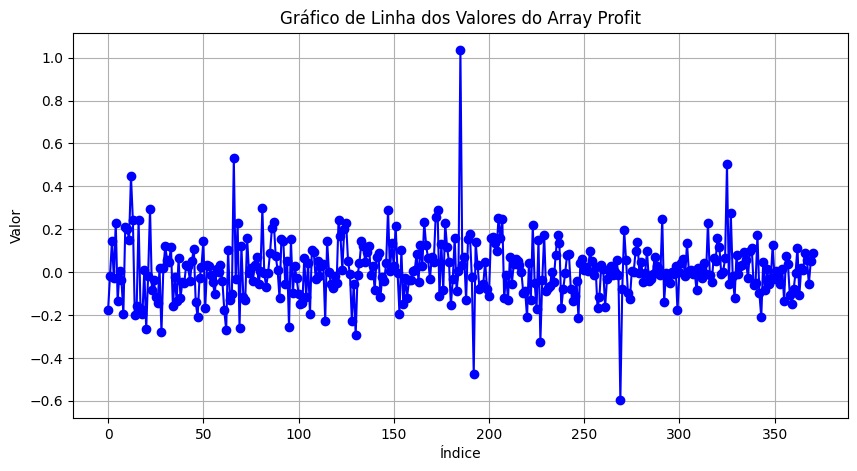

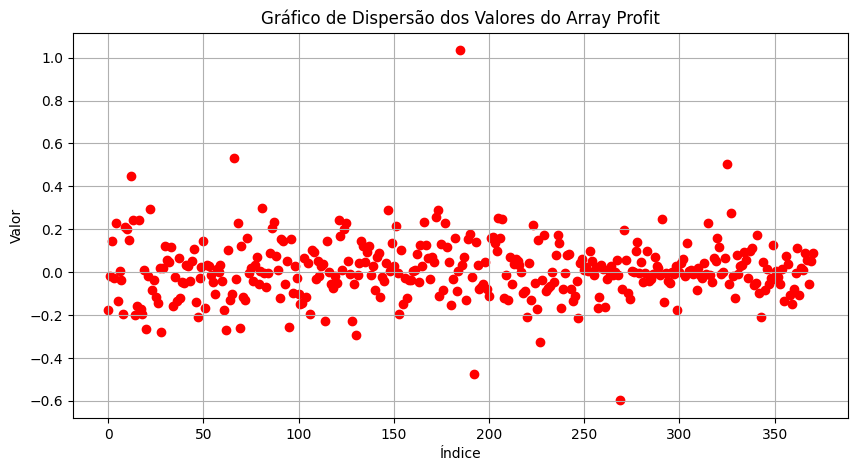

In [938]:
# Gráfico de linha
plt.figure(figsize=(10, 5))  # Define o tamanho da figura
plt.plot(profit, marker='o', linestyle='-', color='b')
plt.title('Gráfico de Linha dos Valores do Array Profit')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

# Gráfico de dispersão (scatter plot)
plt.figure(figsize=(10, 5))
plt.scatter(range(len(profit)), profit, color='r')
plt.title('Gráfico de Dispersão dos Valores do Array Profit')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.grid(True)
plt.show()

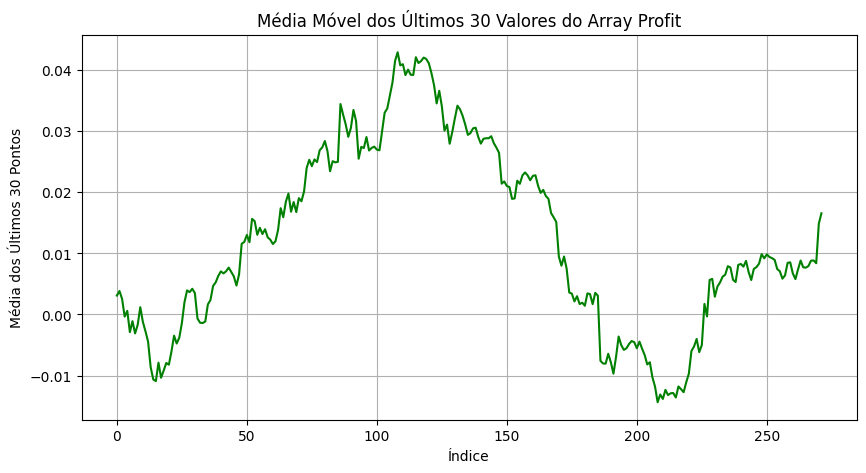

In [951]:
# Tamanho da janela de média móvel
window_size = 100

# Calcular a média móvel
rolling_mean = np.convolve(profit, np.ones(window_size)/window_size, mode='valid')

# Gráfico da média móvel
plt.figure(figsize=(10, 5))
plt.plot(rolling_mean, linestyle='-', color='g')
plt.title('Média Móvel dos Últimos 30 Valores do Array Profit')
plt.xlabel('Índice')
plt.ylabel('Média dos Últimos 30 Pontos')
plt.grid(True)
plt.show()